In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib
#matplotlib.use('nbagg')

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [2]:
rootdir = Path("/mnt/d/wfsdat")
# use find to make this csv list
with open(rootdir / "2020_q3_csvs.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [3]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,5556,1,binospec,5556
f5,346,1,f5,346


In [4]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[fixed['time'] > "2019-12-30"]

In [5]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,focerr,cc_x_err,cc_y_err,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms
18,2020-07-01T03:36:32.832000,f5,test_0004.fits,1.0,1.5037,226.663297,41.684681,14.00,14.2,13.985,...,56.03,-7.361,21.975,220.005780,263.001668,0.678168,0.866231,5.639643,1581.171340,1599.005803
0,2020-07-01T03:37:48.864000,f5,manual_wfs_0000.fits,40.0,1.5094,226.991824,41.490758,14.00,14.2,13.969,...,39.18,-8.575,23.443,232.010525,267.015454,1.205151,1.542851,8.740833,1257.606317,1128.823770
1,2020-07-01T03:39:08.352000,f5,manual_wfs_0001.fits,30.0,1.5157,227.339417,41.283058,14.00,14.2,13.962,...,-0.10,-1.357,0.000,229.983289,260.984259,1.122169,1.440211,8.281206,403.579771,1133.331132
2,2020-07-01T03:40:23.520000,f5,manual_wfs_0002.fits,30.0,1.5216,227.662945,41.087257,14.00,14.2,13.935,...,-10.33,-1.894,0.000,228.011741,266.013169,1.284905,1.652918,9.229636,392.053800,1218.806918
19,2020-07-01T04:42:24.768000,f5,test_0005.fits,1.0,1.2624,249.335623,52.387929,13.00,13.4,13.177,...,-34.52,-0.540,-0.000,236.011195,240.986226,0.795683,0.915079,5.869067,879.009520,1697.876512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,2020-09-30T09:50:19.680000,f5,manual_wfs_0035.fits,30.0,1.5262,171.043553,40.936849,15.50,16.1,15.664,...,20.31,-0.000,-0.000,245.985475,243.986719,1.005603,1.295966,7.628842,571.514058,1634.111910
33,2020-09-30T09:51:40.032000,f5,manual_wfs_0036.fits,30.0,1.5248,171.465518,40.981996,15.50,16.3,15.674,...,7.49,-3.004,0.000,244.024365,242.023720,0.985575,1.269455,7.508108,370.156508,1597.190287
34,2020-09-30T10:51:01.440000,f5,manual_wfs_0037.fits,30.0,1.5845,199.108406,39.133514,14.75,16.3,15.677,...,-25.71,-4.859,1.701,243.000471,234.016905,1.210368,1.595339,8.974445,763.269619,1707.582944
35,2020-09-30T10:51:56.736000,f5,manual_wfs_0038.fits,30.0,1.5866,199.381401,39.069710,14.75,16.3,15.616,...,-12.29,0.000,-0.000,247.987238,235.989441,1.014128,1.337745,7.818580,437.829878,1634.723574


In [6]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 576x360 with 0 Axes>

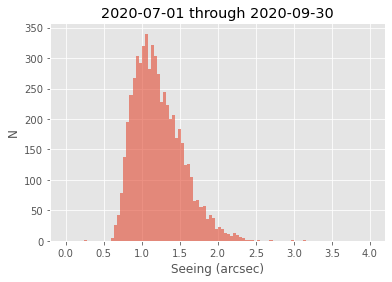

In [7]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
plt.title("2020-07-01 through 2020-09-30")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [8]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.27936727118716465 0.11979562768343546 1.0603633109731512


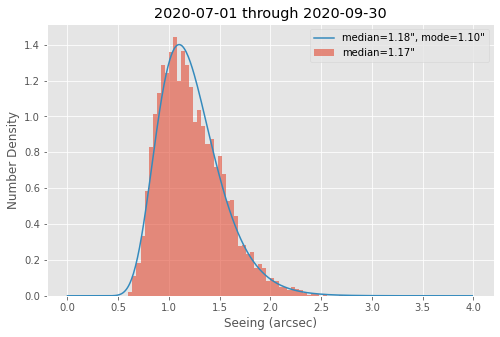

In [9]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Number Density")
plt.title("2020-07-01 through 2020-09-30")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.savefig("2020q3_hist.png")
plt.show()

In [14]:
fixed['seeing']['2020']

ut
2020-07-01 03:37:48.864    1.205151
2020-07-01 03:39:08.352    1.122169
2020-07-01 03:40:23.520    1.284905
2020-07-01 04:43:19.200    1.056297
2020-07-01 04:44:54.240    1.161566
                             ...   
2020-09-30 09:50:19.680    1.005603
2020-09-30 09:51:40.032    0.985575
2020-09-30 10:51:01.440    1.210368
2020-09-30 10:51:56.736    1.014128
2020-09-30 10:53:01.536    1.017551
Name: seeing, Length: 5891, dtype: float64

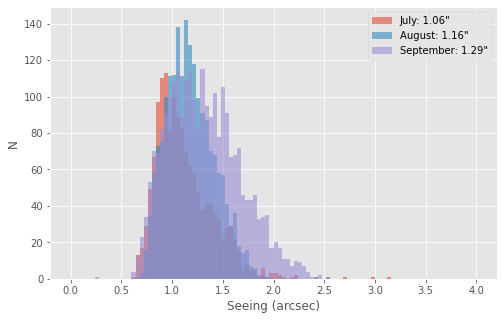

In [15]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['July'] = fixed['seeing']['2020-07']
months['August'] = fixed['seeing']['2020-08']
months['September'] = fixed['seeing']['2020-09']
for m in months:
    plt.hist(months[m], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2020q3_monthly.png")
plt.show()

In [16]:
len(months['July']), len(months['August']), len(months['September'])

(1439, 1922, 2530)

In [17]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

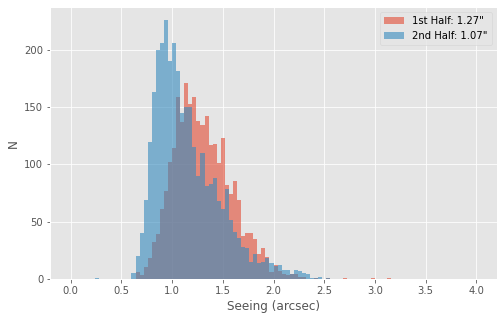

In [18]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2020q3_1st2nd.png")
plt.show()

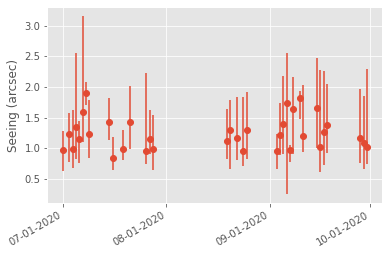

In [19]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('D').median()
daily['max'] = fixed.seeing.resample('D').max()
daily['min'] = fixed.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2020q3_nightly.pdf")
plt.show()

In [21]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed['seeing'][date]) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

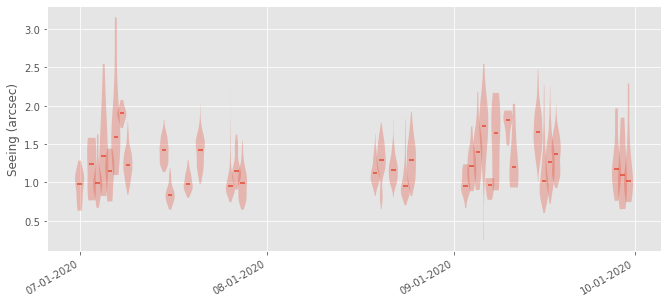

In [22]:
fig, ax = plt.subplots(figsize=(11,5))
plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
               showextrema=False, showmedians=True, bw_method='silverman')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
plt.savefig("2020q3_violin.pdf")
plt.show()